# P7 - Convolutional Neural Networks (CNNs)
We have now learned about the Perceptron, Linear and logistic regression, Multi-layer perceptron and backpropagation, Auto-encoders.

In this pratical session about Convolutional Neural Networks (CNNs) we will use the MNIST datasets.

First, we will obtain baselines using a Logistic Regression and a Feed-forward Neural Network.

## 0.0 - Imports
We will need to import some libraries to be used in this session. Libraries include data visualizers ([matplotlib](https://matplotlib.org/)), neural network package ([torch](https://pytorch.org/)), and other helper packages for data handling ([sklearn](https://scikit-learn.org/), [numpy](https://numpy.org/)).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

Then, other variable definitions are needed to be set. This includes the size of the dataset we will use, and the configuration of the GPU to be activated:

In [2]:
# Configure Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 0.1 - Create Dataloaders
#### MNIST dataset
Using torchvision we can easily download and use the MNIST dataset to create our train and validation dataloaders

In [3]:
# Define tranform - Convert data to tensor and normalize using dataset mean and std
# mean and std are computed offline using the training dataset
# tranforms.Normalize expects a value of mean and std per image channel
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# Download and create MNIST train and validation dataloaders
mnist_train_dataset = datasets.MNIST('../data', download=True, train=True, transform=mnist_transform)
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloaders to get data into numpy for Logistic Regression
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_train = next(iter(mnist_train_dataloader_numpy))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_train = X_y_train[0].numpy()
y_train = X_y_train[1].numpy()
X_val = X_y_val[0].numpy()
y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.50MB/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 259kB/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.09MB/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



We can check the MNIST dataset properties such as:

- shape of train and validation datasets - \[number of samples, width, height\]
- number of input feature on the flattened/reshaped input for Logistic Regression or MLP
- shape of train and validation batches - \[batch size, number of channels, width, height\]

In [ ]:
# get batch to extract properties and plot example images
# next(enumerator(dataloader)) -> creates an iterator of the dataloader and gets the next batchß
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))
# info about the dataset
D_in = np.prod(example_imgs.shape[1:]) 
D_out = len(mnist_train_dataloader.dataset.targets.unique())
print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']}) #60000 imagens no dataset de treino e 10000 no de valdidação 
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


We can plot some examples with corresponding labels using the following function. This function can also receive the predicted labels.

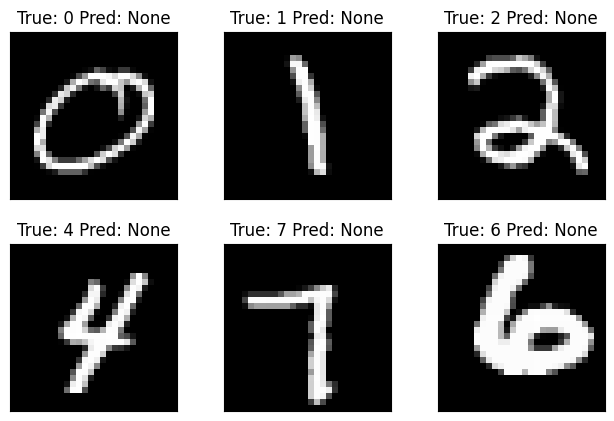

In [8]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))
        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))


## Question 3.1.1
### Logistic Regression

We can use a very simple Logistic Regression that receives our input images as a vector and predicts the digit. This will be our first baseline to compare with the CNNs.

In [11]:
# Use standard scaler to transform input data
scaler = StandardScaler()
X_train= scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1))) #Faz o flateening, pois retorna o vetor com o número de batches mas flattened
X_val=scaler.fit_transform(np.reshape(X_val, (X_val.shape[0], -1)))

# Use scikit-learn Logistic Regression with C=50., multi_class='multinomial', solver='sag', tol=0.1


clf  = LogisticRegression(penalty="l2", C=50, multi_class='multinomial', solver = "sag", tol = 0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

c:\Users\Pedro\OneDrive\Repositories\torch4-life\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test score with penalty: 0.9032


We can select the coefficients for each class and reshape them into the image shape to plot them. This allows us to visualize what are the pixels that are contributing more to the classification for each of the digits.

But what happens if the digits are not centered? Will we still get such a good performance? Lets test that out later!

## Question 3.1.2
### Feed-Forward Neural Network

The first step is to create the functions that will allow us to implement a feed-forward neural network and manage the training and validation process.

The MLP class will define the architecture of a feed-forward neural network, with a set of hidden layers (fully connected layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), with a activation function in between them ([relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)), and a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) in the last layer. Since the dataset poses a multiclass classification problem, the last layer should have a number of neurons equal to the number of classes.

In [16]:
class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        self.dim_layers = dim_layers
        layer_list = [nn.Linear(dim_layers[l], dim_layers[l+1]) for l in range((len(dim_layers)) - 1)]  
        self.layers = nn.ModuleList(layer_list) 
        self.activation = nn.ReLU()

    def forward(self, X):
        x = X.view(-1, self.dim_layers[0]) #dim_layers tem que ser uma lista cujo valor inicial é 784
        for layer in self.layers:
            x = self.activation(layer(x))   
        # use softmax for output layer
        return x 

##### training validation function for the MLP and CNN

In [27]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #Copia estado do modelo atualmente recebido 
    best_acc = 0.0

    # init dictionaries to save losses and accuracies of training and validation
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])  

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

        # execute a training and validation phase for each epoch
        #Bm Bloco de código de forma a determinar 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set the parameter gradients to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # if in training phase, perform backward prop and optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # increment loss and correct counts
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / nsamples
            epoch_acc = (running_corrects.double() / nsamples).item()

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

### Blocos de código importantes neste Notebook: 
0 - Criação dos dicionários qie armazenam as losses e as accs para validação e treino de cada época: 
```python
losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])  

```
    
1 - Dependendo da variável que é passada como estado, define-se o modelo em modo treino ou avaliação




for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # set model to train mode
            else:
                model.eval()   # Set model to eval mode


2 - É importante usar a função torch.set_grad_enabled(phase = "Train") em vez de torch.no_grad()
```python 
for phase in ['train', 'val']:
    for inputs, labels in dataloaders[phase]:

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if phase == 'train':
            loss.backward()   # ❌ ERRO
            optimizer.step()
``` 
------------------------------------------ 
```python
        # Forma perfeita de realizar um loop de treino/validação 
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # if in training phase, perform backward prop and optimize
            if phase == 'train':
                loss.backward()
                optimizer.step()    
```

3 - Utilização de um scheduler: scheduler controla dinamicamente a learning rate do otimizador 


```python 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
if scheduler is not None and phase == 'train':
                scheduler.step()
   ```

4  - Utilização de logs opcionais, através do parâmetro log_interval: 
```python 


if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc))

```

5- Guardar o modelo quando a época é a melhor época através da comparação da epoch_acc com a melhor acc de val: 

6 - Load no final do modelo. Depois do loop para todas as épocas

```python

if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#No final do loop sobre as épocas:

model.load_state_dict(best_model_wts)

```

We will start by creating a simple network with some hidden layers. Thus, in addition to the input, it will have 3 fully connected layer which, in this implemetation, is assigned to the input of the MLP Class. We will use the Stochastic Gradient Descend optimizer ([optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with 0.01 learning rate and 0.5 momentum. The loss function to be optimized will be negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). Training and validation will be managed by the function "train_val_model" previously define.

In [14]:
LR = 0.01
MOMENTUM = 0.5  


In [69]:

# instantiate model
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)

# instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss() 

# train and validate model
model, losses, accuracies= train_val_model(model=model_mlp, criterion=criterion, optimizer=optimizer, num_epochs=20, scheduler=scheduler, log_interval=5, dataloaders=dataloaders)
# plot losses



Epoch 1/20
----------
train Loss: 2.2972 Acc: 10.32%
val Loss: 2.2889 Acc: 10.80%

Epoch 6/20
----------
train Loss: 1.7271 Acc: 45.80%
val Loss: 1.6230 Acc: 51.08%

Epoch 11/20
----------
train Loss: 1.1743 Acc: 60.08%
val Loss: 1.1552 Acc: 60.48%

Epoch 16/20
----------
train Loss: 1.1508 Acc: 60.41%
val Loss: 1.1321 Acc: 60.75%

Training complete in 3m 35s
Best val Acc: 61.03%


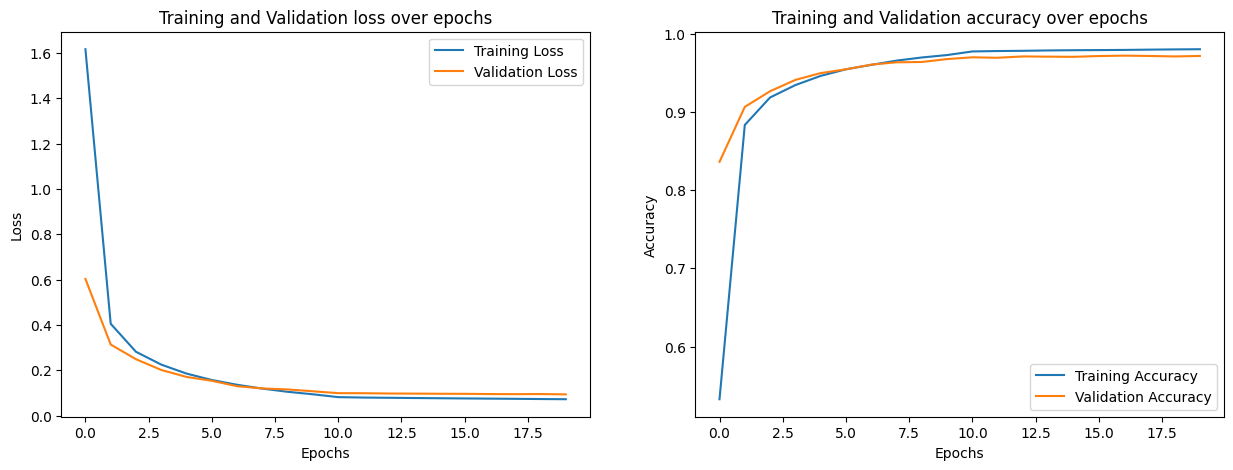

In [30]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(losses["train"], label = "Training Loss")
axs[0].plot(losses["val"], label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(accuracies["train"], label = "Training Accuracy")
axs[1].plot(accuracies["val"], label = "Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

## Question 3.1.3
### Plots of the coefficients of the Logistic Regression for each class

In [ ]:
coef = clf.coef_.copy()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

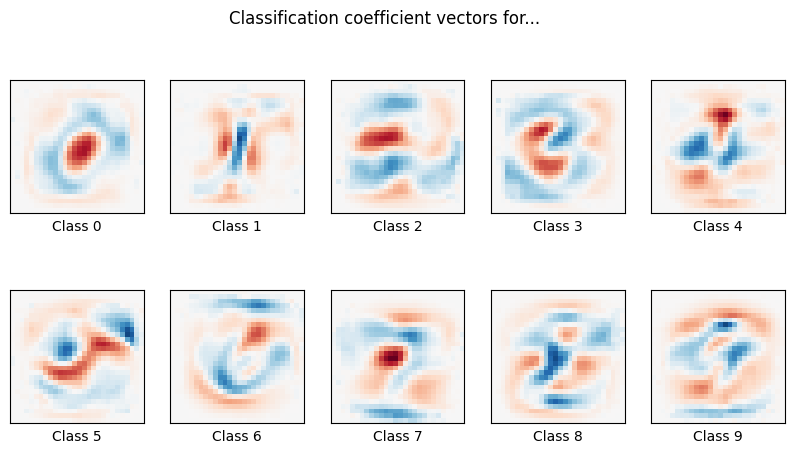

In [40]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    # iterate over the classes and reshape coefficients to ensure proper visualization
    l1_plot.imshow(coef[i].reshape(28,28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

7 - Geração de imagens relativas a representações, basta retirar os vetores de pesos correspondentes a cada class que partem do input, que neste caso possui dimensão 748- 
```python 

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    # iterate over the classes and reshape coefficients to ensure proper visualization
    l1_plot.imshow(coef[i].reshape(28,28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

Olhando para a imagem, nota-se que se vê mesmo os números a aparecerem. Porque esta aprendizagem é feita pixel a pixel 

## Question 3.2
### Convolutional Neural Network

Convolutional layers capture patterns corresponding to relevant features independently of where they occur in the input. To do so, they slide a window over the input and apply the convolution operation with a set of kernels or filters that represent the features. Although it is not their only field of application, convolutional neural networks are mainly praised for their performance on image processing tasks.

The training and validation management for the CNN implementation will be performed as the feed-forward network, however we will have to define the network's architecture.

For that we will implement a CNN class to define how many layers it comprises and how the layers will be connected.

The initialization (`__init__`) function will define the architecture and the `forward` function will implement how the different layers are connected. This architecture will be a sequece of 2 convolutional layers ([nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) (1st: output channels 10, kernel size 5; 2nd: output channels 20, kernel size 5), then 2 fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) (1st: output features 50; 2nd: output features 10 (the number of classes)). Once again, the final layer will be a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) function  that will choose the most probable class of the 10 in the input.

Between the second convolution layer and the first fully connected, we will set a dropout layer ([nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)). The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting.

In [61]:
class CNN(nn.Module):
    """Basic Pytorch CNN for MNIST-like data."""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) 
        self.dropout = nn.Dropout2d(0.3)
        self.linear1 = nn.Linear(320,50) 
        self.linear2 = nn.Linear(50,10) 
        self.max_pooling = nn.MaxPool2d(2,2)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()

        
    def forward(self, x):
        # Batch size = 64, images 28x28 =>
        #     x.shape = [64, 1, 28, 28]
        
        # Convolution with 5x5 filter without padding and 10 channels =>
        #     x.shape = [64, 10, 24, 24] since 24 = 28 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 10, 12, 12]
        x = self.max_pooling(self.conv1(x))
        x = self.max_pooling(self.conv2(x))
        x = self.dropout(x)
        # Convolution with 5x5 filter without padding and 20 channels =>
        #     x.shape = [64, 20, 8, 8] since 8 = 12 - 5 + 1
        # Max pooling with stride of 2 =>
        #     x.shape = [64, 20, 4, 4] => 20 * 4 * 4 
        x = self.flatten(x)
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        

        return x 
        # Reshape =>
        #     x.shape = [64, 320]


As previously, lets describe the model to be trained. We will use the ADAM optimizes ([optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)), with learning rate 0.001, and the same negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

In [59]:
LR = 0.001

Epoch 1/20
----------
train Loss: 0.2636 Acc: 92.28%
val Loss: 0.0793 Acc: 97.57%

Epoch 6/20
----------
train Loss: 0.0495 Acc: 98.45%
val Loss: 0.0408 Acc: 98.68%

Epoch 11/20
----------
train Loss: 0.0355 Acc: 98.86%
val Loss: 0.0400 Acc: 98.93%

Epoch 16/20
----------
train Loss: 0.0278 Acc: 99.12%
val Loss: 0.0406 Acc: 98.90%

Training complete in 4m 6s
Best val Acc: 99.02%


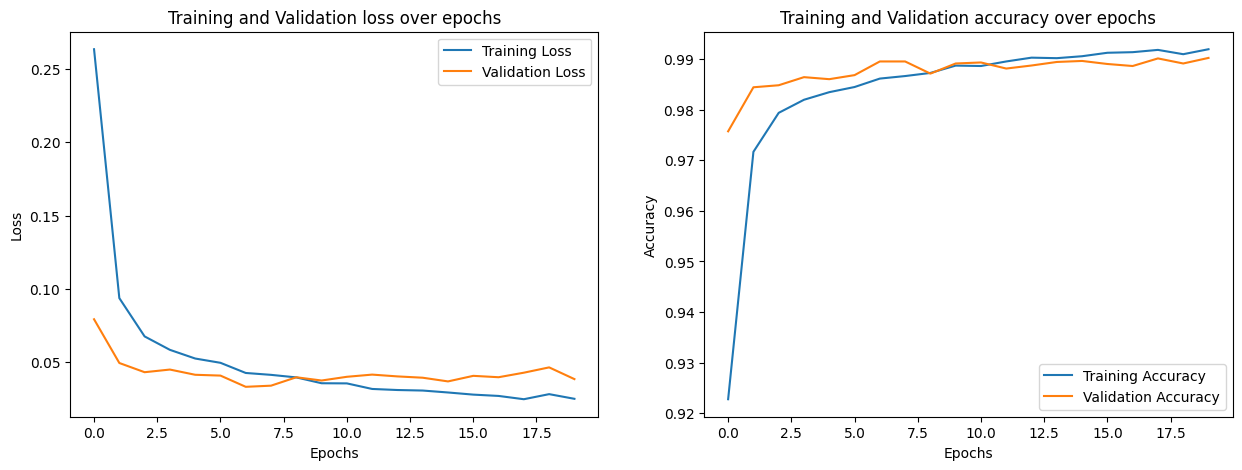

In [76]:
# instatiate the model, optimizer and criterion

# train and validate model


# plot the losses
# instantiate model
model_cnn = CNN().to(device)

# instantiate optimizer and criterion
optimizer = optim.Adam(model_cnn.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss() 

# train and validate model
model, losses, accuracies= train_val_model(model=model_cnn, criterion=criterion, optimizer=optimizer, num_epochs=20, log_interval=5, dataloaders=dataloaders)
# plot losses
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(losses["train"], label = "Training Loss")
axs[0].plot(losses["val"], label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(accuracies["train"], label = "Training Accuracy")
axs[1].plot(accuracies["val"], label = "Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()


We have now completed training and validation with 3 different models: Logistic Regression, Feed-Forward Network, and Convolutional Neural Network.

We have seen that with the CNN, the performance of the model in the validation set, outperforms the other models (~99% accuracy against ~90% and ~98%).

## Question 3.3
### Number of learnable parameters of the MLP and the CNN

The difference in performance between CNNs and MLP is small but how many learnable parameters are we using in the MLP and in CNN models?

We can find it out using the following lines of code:

In [68]:
# get MLP trainable model parameters
params_mlp = sum(p.numel() for p in model_mlp.parameters())
print('Number of parameters in the MLP model: {}'.format(params_mlp))

# get CNN trainable model parameters
params_cnn = sum(p.numel() for p in model_cnn.parameters())
print('Number of parameters in the CNN model: {}'.format(params_cnn))

Number of parameters in the MLP model: 242762
Number of parameters in the CNN model: 21840


You can see that we have ~11x more learnable parameters to achieve almost the same performance.

We can experiment and try to find out the number of layers and corresponding sizes.

## Question 3.4
### Change number of MLP hidden layers to approximate the number of learnable parameters of the CNN. What is the impact on the performance?

In [74]:
# instantiate smaller MLP
model_mlp = MLP([D_in, 32, 32, 16, D_out]).to(device)
params_mlp_test = sum(p.numel() for p in model_mlp.parameters())
print('Number of parameters in the MLP model: {}'.format(params_mlp_test))

Number of parameters in the MLP model: 26874


And how does that model perform? We are about to find out

In [77]:
# instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss() 

# train and validate model
model, losses, accuracies= train_val_model(model=model_mlp, criterion=criterion, optimizer=optimizer, num_epochs=20, scheduler=scheduler, log_interval=5, dataloaders=dataloaders)
# plot losses
# train model


#plot losses
axs[0].plot(losses["train"], label = "Training Loss")
axs[0].plot(losses["val"], label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(accuracies["train"], label = "Training Accuracy")
axs[1].plot(accuracies["val"], label = "Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()


Epoch 1/20
----------
train Loss: 2.2954 Acc: 11.06%
val Loss: 2.2831 Acc: 15.15%

Epoch 6/20
----------
train Loss: 1.5900 Acc: 46.32%
val Loss: 1.5142 Acc: 50.57%

Epoch 11/20
----------
train Loss: 1.1276 Acc: 66.21%
val Loss: 1.1045 Acc: 66.98%

Epoch 16/20
----------
train Loss: 1.0923 Acc: 67.24%
val Loss: 1.0688 Acc: 67.90%

Training complete in 3m 28s
Best val Acc: 68.79%


We can see a drop in performance compared with the previous MLP model. So we can understand that although we have less learnable parameters, due to properties of CNNs (e.g., invariance and parameter sharing), which allow them to have fewer weights as some parameters are shared.

## Question 3.5
### What happens in each of the classifiers if for some reason your validation set does not always have the digits centered in your input image?

CNNs are expected to be invariant to the location where important features occur in the input. In fact, it's not unusual that there is a dataset shift where the data acquisition process suffers some modification. We will do this by applying a transformation with horizontal translations to our validation dataset and see how robust each model is to these shifts.

We can do this by going back to **0.1 - Create Dataloaders -
MNIST dataset** cell to define the test transform using the following code

```
mnist_transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])
```

and replace

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)`

with

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_val)`

In [82]:
# These random translations will be added in the end of this notebook, for now we skip this.
mnist_transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])

# Create MNIST validation dataloaders using transform validation with translation
mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_val)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# MNIST Dataloader for to get data into numpy for Logistic Regression
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))
X_y_val = next(iter(mnist_val_dataloader_numpy))
X_val = X_y_val[0].numpy()

y_val = X_y_val[1].numpy()

dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)

7 - Bloco de transformação: 
ToTensor - Passa para tensor, obriga ao resultado a estar representado de uma forma de tensor. 
RandomAffine - 0 → sem rotação

translate=[0.1, 0] → desloca até 10% da largura horizontalmente, 0 verticalmente

Normalize - normaliza os dados de forma a possuirem uma distribuição normal

```python 
mnist_transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])

#### Logistic Regression

In [87]:
# score the model on the validation dataset after translation
print(X_val.shape)
print(X_val.reshape(-1, 28 * 28).shape) 
score = clf.score(X_val.reshape(10000, 28*28), y_val)
print("Test score with penalty: %.4f" % score)

(10000, 1, 28, 28)
(10000, 784)
Test score with penalty: 0.6198


Compreensão da mecânica do Reshape/View: 
Quando se mete -1 na posição da dimensão, esta é inferida automaticamente. Nas restantes, defini-se um valor que seja concordante, neste caso sendo 28*28 que corresponde a fazer um flattening do vetor. 

#### MLP

In [88]:
# instantiate model
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device)

# instantiate optimizer and criterion
optimizer = optim.SGD(model_mlp.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss() 

# train and validate model
model, losses, accuracies= train_val_model(model=model_mlp, criterion=criterion, optimizer=optimizer, num_epochs=20, scheduler=scheduler, log_interval=5, dataloaders=dataloaders)
# plot losses 


Epoch 1/20
----------
train Loss: 2.2864 Acc: 22.57%
val Loss: 2.2767 Acc: 25.44%

Epoch 6/20
----------
train Loss: 1.1052 Acc: 72.30%
val Loss: 1.3017 Acc: 62.81%

Epoch 11/20
----------
train Loss: 0.6895 Acc: 79.33%
val Loss: 1.0999 Acc: 65.64%

Epoch 16/20
----------
train Loss: 0.6708 Acc: 79.64%
val Loss: 1.0859 Acc: 66.35%

Training complete in 3m 53s
Best val Acc: 66.70%


# Accuracy drop of 25%

#### CNN

Epoch 1/20
----------
train Loss: 0.2472 Acc: 92.50%
val Loss: 0.2274 Acc: 92.86%

Epoch 6/20
----------
train Loss: 0.0476 Acc: 98.55%
val Loss: 0.1567 Acc: 95.42%

Epoch 11/20
----------
train Loss: 0.0349 Acc: 98.90%
val Loss: 0.1488 Acc: 96.02%

Epoch 16/20
----------
train Loss: 0.0257 Acc: 99.15%
val Loss: 0.1380 Acc: 96.62%

Training complete in 4m 17s
Best val Acc: 96.62%


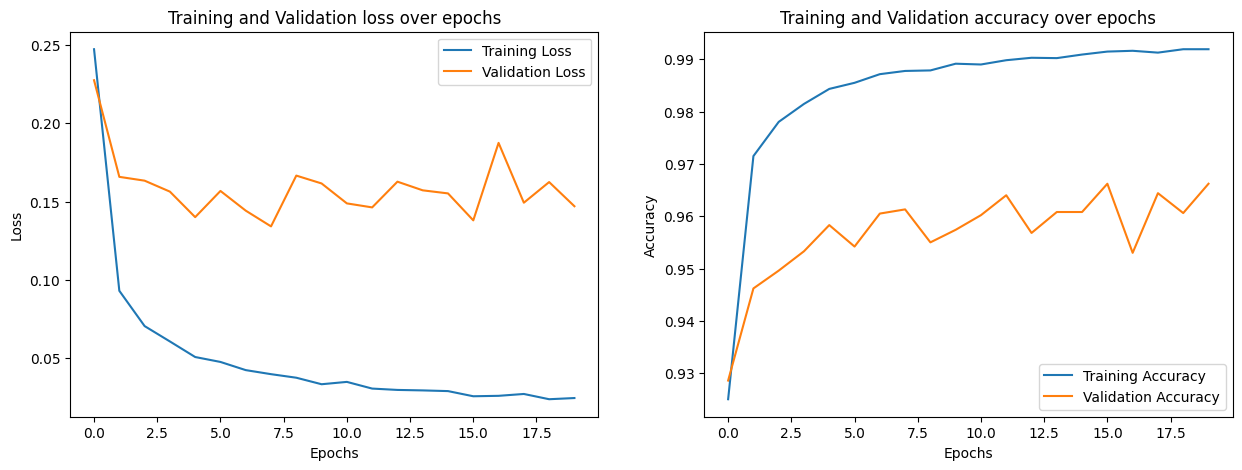

In [89]:
# instantiate model, optimizer and criterion


# train model and obtain loss and accuracy for the translated validation dataset


# plot losses
model_cnn = CNN().to(device)

# instantiate optimizer and criterion
optimizer = optim.Adam(model_cnn.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss() 

# train and validate model
model, losses, accuracies= train_val_model(model=model_cnn, criterion=criterion, optimizer=optimizer, num_epochs=20, log_interval=5, dataloaders=dataloaders)
# plot losses
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(losses["train"], label = "Training Loss")
axs[0].plot(losses["val"], label = "Validation Loss")
axs[0].set_title("Training and Validation loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(accuracies["train"], label = "Training Accuracy")
axs[1].plot(accuracies["val"], label = "Validation Accuracy")
axs[1].set_title("Training and Validation accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()




After rerunning the different models we can see that the accuracy of the Logistic Regression drops from ~90% to ~72%, the MLP drops from ~98% to ~87%, and the CNN drops from ~99% to ~97%. This shows that the learned features are more robust to variances in location, as expected.

# Bonus Case - Attention with small images and CNNs.  (And how to create a dataset that takes numpy arrays)

In this case we will use the Scikit-Learn's digits dataset

## Scikit-Learn Digits

This dataset is provided by scikit-learn and the digit images are returned as numpy ndarray. We will use PIL (Python Image Library) to convert the numpy ndarray to a image, tranform it to a tensor and normalize it.

In this case we don't have a predefined Digits Dataset provided by torchvision so we will need to write a custom Dataset class and implement three functions:

`__init__`, `__len__`, and `__getitem__`.

Scikit-Learn return the digits images and labels as ndarrays. Each digit image is an 8x8 array.

To use the previous CNN, we will use a transform to resize the images to the MNIST image size.

In [91]:
SKLEARN_DIGITS_TRAIN_SIZE = 1247
SKLEARN_DIGITS_VAL_SIZE = 550

class NumpyDataset(Dataset):

  def __init__(self, data, targets, transform=None):
    self.data = torch.from_numpy(data).float()
    self.targets = torch.from_numpy(targets).long()
    self.transform = transform

  def __getitem__(self, index):
    x = np.expand_dims(self.data[index], axis=2)
    y = self.targets[index]
    if self.transform:
        x = self.transform(x)
    return x, y

  def __len__(self):
    return len(self.data)

digits_transform = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       ])

# Get sklearn digits dataset
X, y = load_digits(return_X_y=True)
X = X.reshape((len(X), 8, 8))
y_train = y[:-SKLEARN_DIGITS_VAL_SIZE]
y_val = y[-SKLEARN_DIGITS_VAL_SIZE:]
X_train = X[:-SKLEARN_DIGITS_VAL_SIZE]
X_val = X[-SKLEARN_DIGITS_VAL_SIZE:]

digits_train_dataset = NumpyDataset(X_train, y_train, transform=digits_transform)
digits_val_dataset = NumpyDataset(X_val, y_val, transform=digits_transform)
digits_train_dataloader = torch.utils.data.DataLoader(digits_train_dataset, batch_size=64, shuffle=True)
digits_val_dataloader = torch.utils.data.DataLoader(digits_val_dataset, batch_size=64, shuffle=True)

dataloaders = dict(train=digits_train_dataloader, val=digits_val_dataloader)

8 - No getitem, que é utilizado pelo dataloader quando é se retiram dados para a batch, sendo o número de samples correspondentes à batchsize, é preciso, se existir uma transform, aplicar a transform na indexação. Para além disso, também é necessário expandir as dimensões de x de forma a puder ter o número da batch, ou seja, seja stacked nessa dimensão!


```python
def __getitem__(self, index):
    x = np.expand_dims(self.data[index], axis=2)
    y = self.targets[index]
    if self.transform:
        x = self.transform(x)
    return x, y

```

In [92]:
# Get some examples of images and targets
_, (example_train_imgs, example_train_targets) = next(enumerate(digits_train_dataloader))
_, (example_val_imgs, example_val_targets) = next(enumerate(digits_val_dataloader))

# Info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(digits_train_dataloader.dataset.targets.unique())

# Output information
print("Datasets shapes (before transformations):", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_train_imgs.shape, example_train_targets.shape)
print("Val batch:", example_val_imgs.shape, example_val_targets.shape)

Datasets shapes (before transformations): {'train': torch.Size([1247, 8, 8]), 'val': torch.Size([550, 8, 8])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


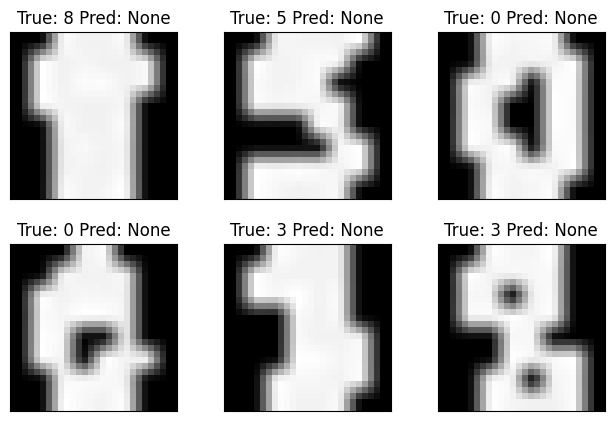

In [93]:
plot_img_label_prediction(imgs=example_train_imgs, y_true=example_train_targets, y_pred=None, shape=(2, 3))


### Logistic Regression

In [94]:
scaler = StandardScaler()
print(X_train.squeeze().shape)
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50., multi_class='multinomial', solver='sag', tol=0.1)
clf.fit(X_train, y_train)
#sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

(1247, 8, 8)
Test score with penalty: 0.8927


c:\Users\Pedro\OneDrive\Repositories\torch4-life\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


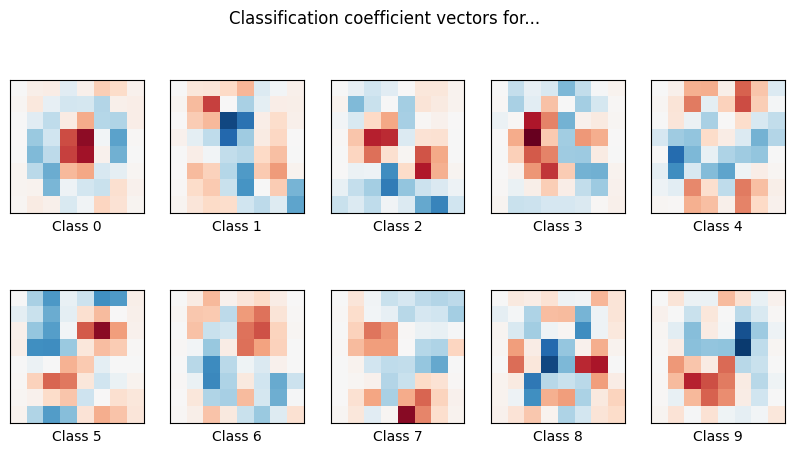

In [95]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(8, 8), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

### Feed-forward using digits dataset

Epoch 1/20
----------
train Loss: -0.0473 Acc: 12.19%
val Loss: -0.0709 Acc: 12.55%

Epoch 3/20
----------
train Loss: -0.1527 Acc: 9.94%
val Loss: -0.1995 Acc: 10.18%

Epoch 5/20
----------
train Loss: -2.8794 Acc: 9.94%
val Loss: -48.6504 Acc: 10.18%

Epoch 7/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 9/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 11/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 13/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 15/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 17/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Epoch 19/20
----------
train Loss: nan Acc: 10.02%
val Loss: nan Acc: 9.64%

Training complete in 0m 5s
Best val Acc: 12.55%


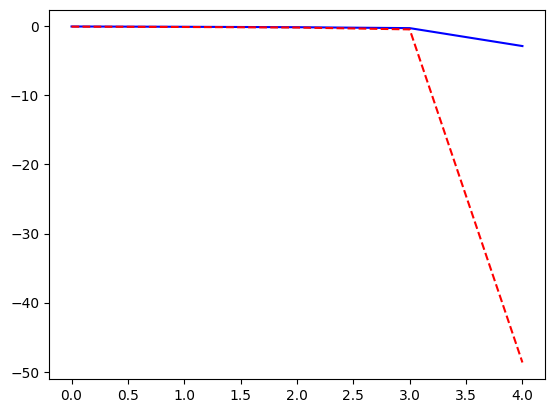

In [96]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

Epoch 1/50
----------
train Loss: -1.9047 Acc: 11.07%
val Loss: -10.2316 Acc: 12.91%

Epoch 11/50
----------
train Loss: -1230254.7829 Acc: 10.26%
val Loss: -1540930.9068 Acc: 10.00%

Epoch 21/50
----------
train Loss: -28073305.9006 Acc: 10.26%
val Loss: -31086705.7673 Acc: 10.00%

Epoch 31/50
----------
train Loss: -154860162.1556 Acc: 10.26%
val Loss: -163859339.1127 Acc: 10.00%

Epoch 41/50
----------
train Loss: -487588654.0626 Acc: 10.26%
val Loss: -510754004.8291 Acc: 10.00%

Training complete in 0m 13s
Best val Acc: 12.91%


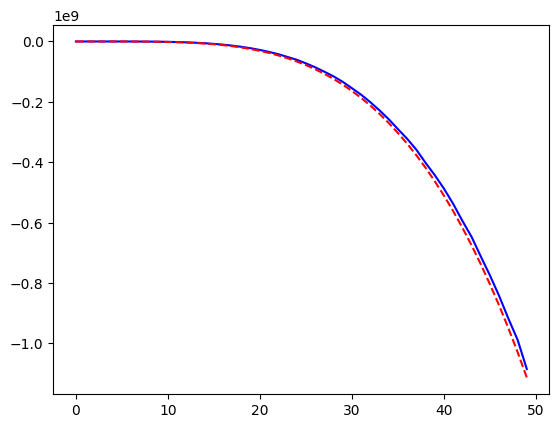

In [97]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=50, log_interval=10)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

# Bonus Information - Visualizing CNN filters

Some work have been done to demonstrate the type of features learned by different filters in different layers.

For instance, considering a known CNN called **VGG16** which has the following architecture

![image](https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg)\[taken from: https://www.geeksforgeeks.org/vgg-16-cnn-model/ \]

these would be some of the filters from some of the layers:
<table border=0 width="500px" >
	<tbody>
		<tr>
			<td width="19%" align="center"> Layer 2 <br /> (Conv 1-2)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f1.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f21.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l2_f54.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 10 <br /> (Conv 2-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f7.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f10.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l10_f69.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 17 <br /> (Conv 3-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f4.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f8.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l17_f9.jpg"> </td>
		</tr>
		<tr>
			<td width="19%" align="center"> Layer 24 <br /> (Conv 4-1)</td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f4.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f17.jpg"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/results/layer_visualizations/layer_vis_l24_f22.jpg"> </td>
		</tr>
	</tbody>
</table>

or obtain the class activations:
<table border=0 width="500px" >
	<tbody>
    <tr>		<td width="27%" align="center"> Input Image </td>
			<td width="27%" align="center"> Layer Vis. (Filter=0)</td>
			<td width="27%" align="center"> Filter Vis. (Layer=29)</td>
		</tr>
<tr>
			<td width="27%"> <img src="https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png"> </td>
			<td width="27%"> <img src="https://raw.githubusercontent.com/utkuozbulak/cnn-gifs/master/spider_layer_graph.gif"> </td>
			<td width="27%" align="center"> <img src="https://raw.githubusercontent.com/utkuozbulak/cnn-gifs/master/spider_filter_graph.gif"> </td>
		</tr>
	</tbody>
</table>

\[examples taken from: http://www.github.com/utkuozbulak/pytorch-cnn-visualizations \]


# Bonus Information - Predefined architectures, pre-trained models and transfer learning

Packages like [torchvision](https://pytorch.org/vision/stable/index.html) and [timm](https://rwightman.github.io/pytorch-image-models/) offer you the possibility of using predefined architectures or even use pre-trained models that can be used to fine tune the models for that same task or used for transfer learning.

Besides datasets, transforms and others, **Torchvision** has a large number of predefined architecture with the possibility of loading the pre-trained weights.

#### Torchvision classification models examples



In [ ]:
import torchvision.models as models

# construct a model with random weights to be trained
resnet18 = models.resnet18()

# load a pre-trained model
resnet18 = models.resnet18(pretrained=True)

c:\Users\Pedro\OneDrive\Repositories\torch4-life\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pedro\OneDrive\Repositories\torch4-life\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Pedro/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.7MB/s]


For examples of different models and how to use pre-trained weights please visit https://pytorch.org/vision/stable/models.html#



Another possibility is **timm** which contains models for classification only.
In **timm** you are not restricted to have inputs only with 1/3-channels, allowing you to use architectures or pre-trained models using images that have 2 or > 3-channels.

#### timm classification models examples

### timm tem modelos para classificação só! Aqui podemos usar casos em que temos mais de 2,3, 4 chanels... 

In [106]:
if 'google.colab' in str(get_ipython()):
  !pip install -q timm
import timm

# list all models
print(timm.list_models())

# list pre-trained models
print(timm.list_models(pretrained=True))

# list models architectures by wildcards
print(timm.list_models('*resne*t*'))

# construct a model with random weights to be trained
model = timm.create_model('resnet18')

# load a pre-trained model
model = timm.create_model('resnet18', pretrained=True)

['aimv2_1b_patch14_224', 'aimv2_1b_patch14_336', 'aimv2_1b_patch14_448', 'aimv2_3b_patch14_224', 'aimv2_3b_patch14_336', 'aimv2_3b_patch14_448', 'aimv2_huge_patch14_224', 'aimv2_huge_patch14_336', 'aimv2_huge_patch14_448', 'aimv2_large_patch14_224', 'aimv2_large_patch14_336', 'aimv2_large_patch14_448', 'bat_resnext26ts', 'beit3_base_patch16_224', 'beit3_giant_patch14_224', 'beit3_giant_patch14_336', 'beit3_large_patch16_224', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_s

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

c:\Users\Pedro\OneDrive\Repositories\torch4-life\venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pedro\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


For more details on how to use this package visit https://rwightman.github.io/pytorch-image-models/